In [1]:
#cd t:\freely_moving_ephys\ephys_recordings\101120\G6H28P6LT\hf4_wn

In [2]:
cd \\niell-v2-w7\freely_moving_ephys\ephys_recordings\092820\J524RT\outputs_Oct07a


\\niell-v2-w7\freely_moving_ephys\ephys_recordings\092820\J524RT\outputs_Oct07a


In [3]:
ls

 Volume in drive Z is 4tb v3
 Volume Serial Number is 7E54-BBD3

 Directory of Z:\ephys_recordings\092820\J524RT\outputs_Oct07a

10/14/2020  05:21 PM    <DIR>          .
10/14/2020  05:21 PM    <DIR>          ..
10/13/2020  04:25 PM             1,341 092820_fm1.csv
10/13/2020  10:00 PM         2,069,136 092820_fm1.hdf
10/13/2020  10:15 PM         1,978,306 092820_fm1.json
10/07/2020  11:39 PM         3,707,007 092820_J524RT_fm1_ephys.json
10/07/2020  11:46 PM       563,461,730 092820_J524RT_fm1_REYE_plot.avi
10/13/2020  09:50 PM     1,185,703,027 092820_J524RT_fm1_TOP1.nc
10/08/2020  12:04 AM     1,962,888,524 092820_J524RT_fm1Reye.nc
10/08/2020  12:30 AM     1,486,082,083 092820_J524RT_fm1world.nc
10/08/2020  12:30 AM        31,427,090 092820_J524RT_ir_led_hf_REYE_plot.avi
10/08/2020  12:31 AM       143,201,005 092820_J524RT_ir_led_hfReye.nc
10/08/2020  12:32 AM       168,541,489 092820_J524RT_ir_led_hfworld.nc
10/08/2020  12:32 AM         1,167,980 092820_J524RT_whitenoise_hf_ephys.j

In [4]:
eye_file =   "101120_G6H28P6LT_hf4_wnReye.nc"
world_file = '101120_G6H28P6LT_hf4_wnworld.nc'
ephys_file = '101120_G6H28P6LT_hf4_wn_ephys.json'

#eye_file =   "101220_G6H28P6LT_fm1Reye.nc"
#world_file = '101220_G6H28P6LT_fm1world.nc'
#ephys_file = '101220_G6H28P6LT_fm1_ephys.json'


world_file = r'092820_J524RT_fm1world.nc'
eye_file = '092820_J524RT_fm1Reye.nc'
ephys_file = '092820_J524RT_fm1_ephys.json'
top_file = '092820_J524RT_fm1_TOP1.nc'

#eye_file = '092820_J524RT_whitenoise_hfReye.nc'
#world_file = '092820_J524RT_whitenoise_hfworld.nc'
#ephys_file = '092820_J524RT_whitenoise_hf_ephys.json'

In [39]:
from netCDF4 import Dataset
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pickle
import time
from matplotlib.animation import FFMpegWriter
import matplotlib as mpl 
import wavio
mpl.rcParams['animation.ffmpeg_path'] = r'C:\Program Files\ffmpeg\bin\ffmpeg.exe'
from scipy.interpolate import interp1d
from numpy import nan

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [6]:
top_data = xr.open_dataset(top_file)
top_vid = np.uint8(top_data['TOP1_video'])
top_data

<xarray.Dataset>
Dimensions:     (frame: 71522, height: 270, point_loc: 33, width: 360)
Coordinates:
  * frame       (frame) int64 0 1 2 3 4 5 ... 71517 71518 71519 71520 71521
    timestamps  (frame) float64 ...
  * point_loc   (point_loc) object 'nose_x' ... 'base_implant_likelihood'
    trial       object ...
Dimensions without coordinates: height, width
Data variables:
    TOP1_pts    (point_loc, frame) float64 ...
    TOP1_video  (frame, height, width) int8

In [7]:
top_vid = np.uint8(top_data['TOP1_video'])
topT = top_data['timestamps']
topT

<xarray.DataArray 'timestamps' (frame: 71522)>
array([44440.675187, 44440.689382, 44440.705984, ..., 45633.047001,
       45633.063654, 45633.067213])
Coordinates:
  * frame       (frame) int64 0 1 2 3 4 5 ... 71517 71518 71519 71520 71521
    timestamps  (frame) float64 4.444e+04 4.444e+04 ... 4.563e+04 4.563e+04
    trial       <U22 '092820_J524RT_fm1_TOP1'

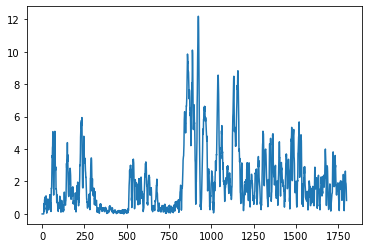

In [31]:
# get points from top cam to calculate locomotion
# base of spine seems most reliable
ptNames = top_data['TOP1_pts']
spinex = ptNames.sel(point_loc = 'spine_x')
spiney = ptNames.sel(point_loc = 'spine_y')
spinep = ptNames.sel(point_loc = 'spine_likelihood')

#smooth pts before calculating speed
box = np.ones(11)/11
spinex = np.convolve(spinex, box, mode='same')
spiney = np.convolve(spiney,box,mode = 'same')

#speed
sp = np.sqrt(np.diff(spinex)**2 + np.diff(spiney)**2)*60/10
sp[0:10]=0
plt.plot(sp[0:1800])

In [9]:
# load worldcam
world_data = xr.open_dataset(world_file)
world_vid_raw = np.uint8(world_data['WORLD_video'])



In [10]:
#resize worldcam to make more manageable
sz = world_vid_raw.shape
downsamp = 0.25
world_vid = np.zeros((sz[0],np.int(sz[1]*downsamp),np.int(sz[2]*downsamp)), dtype = 'uint8')
for f in range(sz[0]):
    world_vid[f,:,:] = cv2.resize(world_vid_raw[f,:,:],(np.int(sz[2]*downsamp),np.int(sz[1]*downsamp)))
worldT = world_data.timestamps
world_data

<xarray.Dataset>
Dimensions:      (frame: 60977, height: 240, width: 320)
Coordinates:
  * frame        (frame) int64 0 1 2 3 4 5 ... 60972 60973 60974 60975 60976
    timestamps   (frame) float64 ...
Dimensions without coordinates: height, width
Data variables:
    WORLD_times  (frame) float64 ...
    WORLD_video  (frame, height, width) int8 24 -113 108 115 ... 114 113 114 113

Text(0.5, 0, 'deltaT')

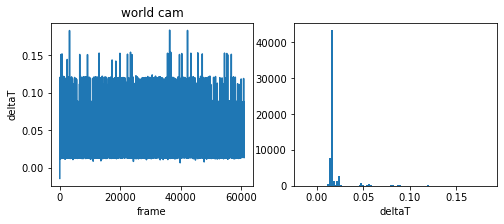

In [12]:
# plot worldcam timing
fig, axs = plt.subplots(1,2,figsize=(8,3))
axs[0].plot(np.diff(worldT)); axs[0].set_xlabel('frame'); axs[0].set_ylabel('deltaT'); axs[0].set_title('world cam')
axs[1].hist(np.diff(worldT),100);axs[1].set_xlabel('deltaT')

Text(0.5, 1.0, 'mean worldcam')

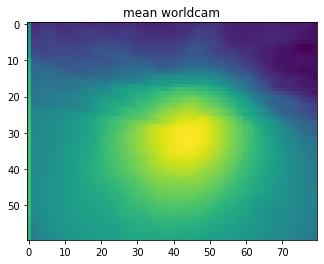

In [13]:
# plot mean world image
plt.imshow(np.mean(world_vid,axis=0)); plt.title('mean worldcam')

In [14]:
# read ephys data
ephys_data = pd.read_json(ephys_file)
ephys_data


,Amplitude,ContamPct,KSLabel,amp,ch,depth,fr,group,n_spikes,sh,spikeT,waveform,t0
0,383.9,8.9,good,31.474401,0,1,9.410262,good,11219,0,"[0.005200000000000001, 0.1723, 0.3153666667, 0...","[-0.0043589817, -0.0055342452, -0.0068012639, ...",44440.826854
1,315.4,39.3,mua,23.014782,0,1,4.292032,noise,5117,0,"[0.3441333333, 0.37420000000000003, 0.6085, 0....","[-0.0084317792, -0.0073682186, -0.0058965264, ...",44440.826854
2,427.5,6.7,good,33.772884,0,1,4.480758,good,5342,0,"[0.2502333333, 0.3950666667, 0.4000333333, 0.4...","[7.20132e-05, -0.014391127, -0.010996173100000...",44440.826854
3,212.9,0.3,good,14.963311,3,4,52.519312,noise,62614,0,"[0.0135, 0.0301666667, 0.038666666700000005, 0...","[-0.0052585383, 0.037936274, 0.0337595865, 0.0...",44440.826854
4,419.4,7688.6,mua,14.540514,5,6,0.119945,noise,143,0,"[1.2057333333, 1.2063333333, 1.2069333333, 1.2...","[-0.0398195833, -0.040726833000000004, -0.0230...",44440.826854
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,227.9,41.4,mua,15.748152,14,15,1.347079,noise,1606,0,"[0.1720666667, 1.2078, 1.2083, 1.2083666667, 5...","[-0.028306337100000002, -0.0157045126, -0.0144...",44440.826854
61,407.9,433.3,mua,24.803701,12,13,0.102331,noise,122,0,"[1.2079666667, 1.2081333333, 4.1210333333, 24....","[0.0061434517, -0.011211108400000001, -0.01099...",44440.826854
62,444.9,64.6,mua,28.681179,15,16,1.807569,noise,2155,0,"[0.4181, 1.2067666667, 1.7301666667000002, 4.2...","[0.0123204067, -0.0176212471, -0.010032489, -0...",44440.826854
63,880.2,7.3,good,46.786968,5,6,2.664801,good,3177,0,"[0.1915, 0.9548333333000001, 1.2069333333, 1.2...","[0.0278140716, 0.018410490800000002, 0.0204440...",44440.826854


In [15]:
# get intitial ephys timepoint (t0)
ephysT0 = ephys_data.iloc[0,12]
ephysT0 

44440.826854

In [16]:
# select good cells from phy2
goodcells = ephys_data.loc[ephys_data['group']=='good']
goodcells.shape
units = goodcells.index.values
units

array([ 0,  2,  5, 13, 22, 23, 27, 31, 35, 36, 43, 63, 64], dtype=int64)

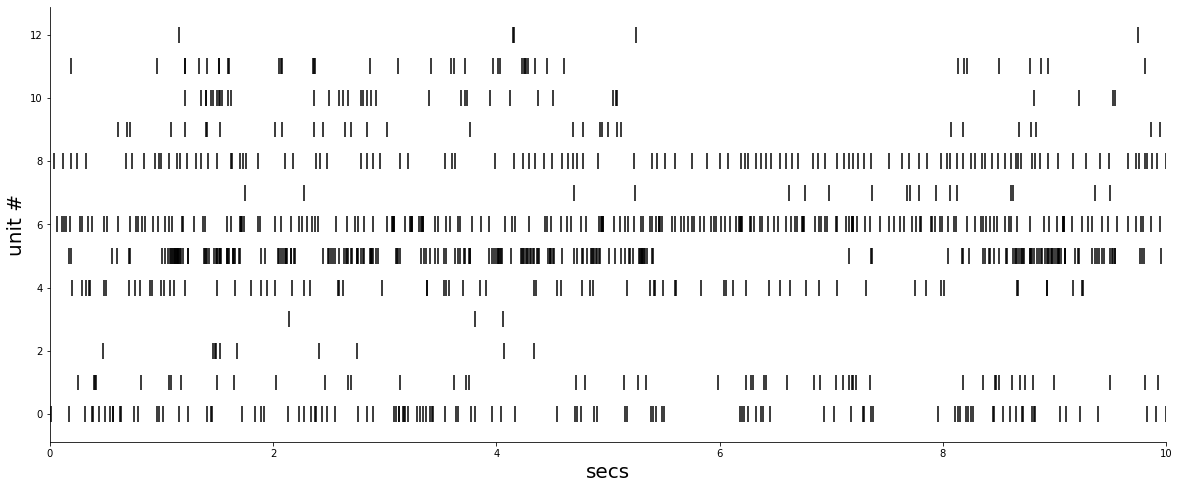

In [17]:
#spike rasters
fig, ax = plt.subplots(figsize=(20,8))
ax.fontsize = 20
for i,ind in enumerate(goodcells.index):
   plt.vlines(goodcells.at[ind,'spikeT'],i-0.25,i+0.25)
   plt.xlim(0, 10); plt.xlabel('secs',fontsize = 20); plt.ylabel('unit #',fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('spikeraster.pdf')



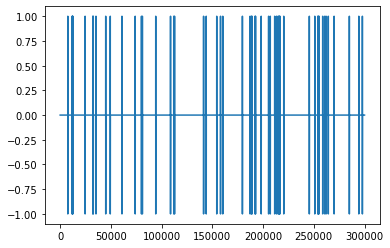

In [18]:
# generate wave file
spk =np.array(ephys_data.at[units[1],'spikeT'])

datarate = 30000
rate = 44100    # samples per second
Tmax = 10           # sample duration (seconds)
f = 440.0       # sound frequency (Hz)
# Compute waveform samples
t = np.linspace(0, Tmax, Tmax*datarate,endpoint=False)
x = np.zeros(np.size(t))
for spt in spk[spk<Tmax]:
    x[np.int64(spt*datarate) : np.int64(spt*datarate +30)] = 1
    x[np.int64(spt*datarate)+31 : np.int64(spt*datarate +60)] =- 1
plt.plot(x)
    

# Write the samples to a file
wavio.write("spike.wav", x, datarate, sampwidth=1)


<xarray.DataArray 'timestamps' (frame: 64186)>
array([15640.429206, 15640.414749, 15640.430973, ..., 16833.046211,
       16833.062435, 16833.078659])
Coordinates:
  * frame       (frame) int64 0 1 2 3 4 5 ... 64181 64182 64183 64184 64185
    timestamps  (frame) float64 1.564e+04 1.564e+04 ... 1.683e+04 1.683e+04

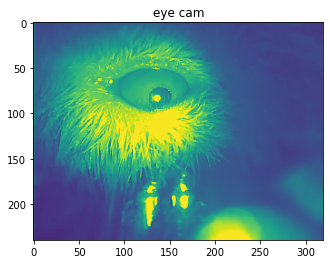

In [19]:
#load eye data
eye_data = xr.open_dataset(eye_file)
eye_vid = np.uint8(eye_data['REYE_video'])
plt.imshow(eye_vid[0,:,:]); plt.title('eye cam')
eyeT = eye_data.timestamps
eyeT

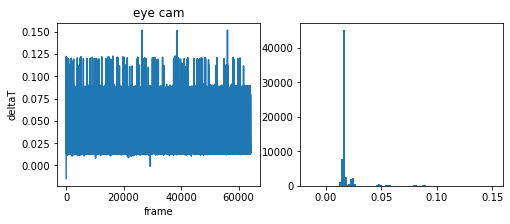

In [20]:
# plot eye timestamps
fig, axs = plt.subplots(1,2,figsize=(8,3))
axs[0].plot(np.diff(eyeT)); axs[0].set_xlabel('frame'); axs[0].set_ylabel('deltaT'); axs[0].set_title('eye cam')
axs[1].hist(np.diff(eyeT),100);

AttributeError: module 'matplotlib.pyplot' has no attribute 'y_label'

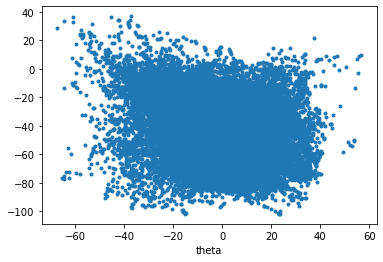

In [45]:
#plot eye postion across recording
eye_params = eye_data['REYE_ellipse_params']
plt.plot(eye_params.sel(ellipse_params = 'theta')*180/3.1415,eye_params.sel(ellipse_params = 'phi')*180/3.1415,'.')
plt.xlabel('theta'); plt.ylabel('phi')

In [23]:
# adjust eye/world/top times relative to ephys
eyeT = eye_data.timestamps  - ephysT0
if eyeT[0]<-600:
    eyeT = eyeT + 8*60*60 # 8hr offset for some data
worldT = world_data.timestamps - ephysT0
if worldT[0]<-600:
    worldT = worldT + 8*60*60
topT = top_data.timestamps - ephysT0
eyeT, worldT,topT

(<xarray.DataArray 'timestamps' (frame: 64186)>
 array([-3.97648000e-01, -4.12105000e-01, -3.95881000e-01, ...,
         1.19221936e+03,  1.19223558e+03,  1.19225180e+03])
 Coordinates:
   * frame       (frame) int64 0 1 2 3 4 5 ... 64181 64182 64183 64184 64185
     timestamps  (frame) float64 1.564e+04 1.564e+04 ... 1.683e+04 1.683e+04,
 <xarray.DataArray 'timestamps' (frame: 60977)>
 array([-3.97795000e-01, -4.12112000e-01, -3.95875000e-01, ...,
         1.19221205e+03,  1.19223374e+03,  1.19224998e+03])
 Coordinates:
   * frame       (frame) int64 0 1 2 3 4 5 ... 60972 60973 60974 60975 60976
     timestamps  (frame) float64 1.564e+04 1.564e+04 ... 1.683e+04 1.683e+04,
 <xarray.DataArray 'timestamps' (frame: 71522)>
 array([-1.51667000e-01, -1.37472000e-01, -1.20870000e-01, ...,
         1.19222015e+03,  1.19223680e+03,  1.19224036e+03])
 Coordinates:
   * frame       (frame) int64 0 1 2 3 4 5 ... 71517 71518 71519 71520 71521
     timestamps  (frame) float64 4.444e+04 4.444e+04 ..

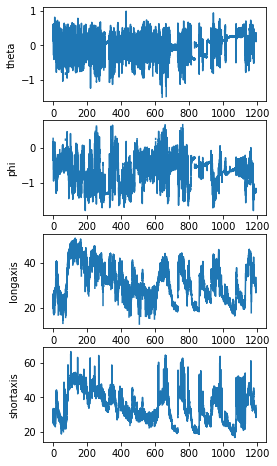

In [24]:
#plot eye variables
fig,axs = plt.subplots(4,1,figsize = (4,8))
for i,val in enumerate(eye_params.ellipse_params[0:4]):
    axs[i].plot(eyeT,eye_params.sel(ellipse_params = val))
    axs[i].set_ylabel(val.values)
    

In [25]:
# calculate eye veloctiy
dEye = np.diff(eye_params.sel(ellipse_params = 'theta'))*180/3.14159
eye_vid.shape

(64186, 240, 320)

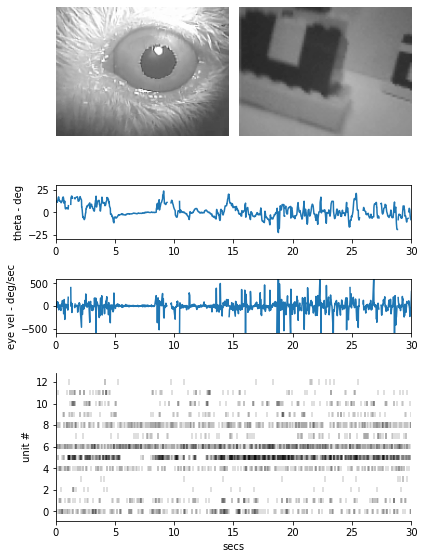

In [26]:
# plot data figure

fig = plt.figure(figsize = (6,8))
gs = fig.add_gridspec(6,2)
axEye = fig.add_subplot(gs[0:2,0])
axWorld = fig.add_subplot(gs[0:2,1])
axTheta = fig.add_subplot(gs[2,:])
axdTheta = fig.add_subplot(gs[3,:])
axR = fig.add_subplot(gs[4:6,:])
#axRad = fig.add_subplot(gs[3,:])

tr = [0,30] # 340-385
fr = np.mean(tr) # time for frame
eyeFr = np.abs(eyeT-fr).argmin(dim = "frame")
worldFr = np.abs(worldT-fr).argmin(dim = "frame")

axEye.cla(); axEye.axis('off'); 
axEye.imshow(eye_vid[eyeFr,:,:],'gray',vmin=0,vmax=255,aspect = "equal")
#axEye.plot(eye_params.sel(ellipse_params = 'X0')[fr]/2,eye_params.sel(ellipse_params = 'Y0')[fr]/2,'r.')
axEye.set_xlim(40,200); axEye.set_ylim(0,120)

axWorld.cla();  axWorld.axis('off'); 
axWorld.imshow(world_vid[worldFr,:,:],'gray',vmin=0,vmax=255,aspect = "equal")
   
#plot eye position
axTheta.cla()
axTheta.plot(eyeT,0.5*eye_params.sel(ellipse_params = 'theta')*180/3.14159)
axTheta.set_xlim(tr[0],tr[1]); 
axTheta.set_ylabel('theta - deg'); axTheta.set_ylim(-30,30)

# plot eye velocity
axdTheta.cla()
axdTheta.plot(eyeT[0:-1],dEye*60/2); ax.set_ylabel('dtheta')
#sacc = np.transpose(np.where(np.abs(dEye)>10))
#axdTheta.plot(sacc,np.sign(dEye[sacc])*20,'.')
axdTheta.set_xlim(tr[0],tr[1]); 
axdTheta.set_ylim(-10*60,10*60); axdTheta.set_ylabel('eye vel - deg/sec')

#axRad.cla()
#axRad.plot(eye_params.sel(ellipse_params = 'longaxis')[frameRange])
#axRad.set_xlim(0,frameRange[-1]-frameRange[0]); 
#axRad.set_ylabel('radius'); axRad.set_xlabel('frame #'); axRad.set_ylim(0,40)

# plot spikes
axR.fontsize = 20
for i,ind in enumerate(goodcells.index):
    axR.vlines(goodcells.at[ind,'spikeT'],i-0.25,i+0.25,'k',linewidth=0.25)
axR.set_xlim(tr[0],tr[1]); axR.set_xlabel('secs'); axR.set_ylabel('unit #')
axR.spines['right'].set_visible(False)
axR.spines['top'].set_visible(False)

plt.tight_layout()

plt.savefig('cams_eyes_spikes_092820_wn_0_30.pdf')

Text(0, 0.5, 'contrast')

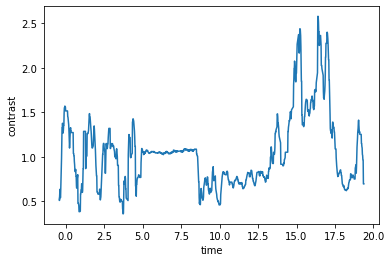

In [27]:
# normalize world movie and calculate contrast
img_norm = (world_vid-np.mean(world_vid,axis=0))/np.std(world_vid,axis=0)
contrast = np.empty(worldT.size)
for i in range(worldT.size):
    contrast[i] = np.std(img_norm[i,:,:])
plt.plot(worldT[0:1000],contrast[0:1000])
plt.xlabel('time')
plt.ylabel('contrast')

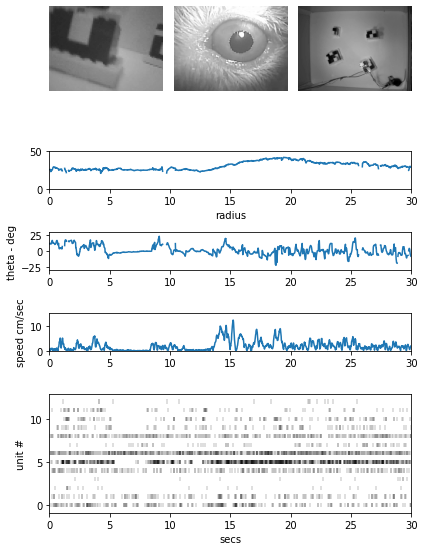

In [44]:
# plot another data figure (with contrast or speed)

fig = plt.figure(figsize = (6,8))
gs = fig.add_gridspec(7,3)
axEye = fig.add_subplot(gs[0:2,1])
axWorld = fig.add_subplot(gs[0:2,0])
axTop = fig.add_subplot(gs[0:2,2])
axTheta = fig.add_subplot(gs[3,:])
axdTheta = fig.add_subplot(gs[4,:])
axVid = fig.add_subplot(gs[2,:])
axR = fig.add_subplot(gs[5:7,:])
#axRad = fig.add_subplot(gs[3,:])

tr = [0,30] # 340-385
fr = np.mean(tr) # time for frame
eyeFr = np.abs(eyeT-fr).argmin(dim = "frame")
worldFr = np.abs(worldT-fr).argmin(dim = "frame")

axEye.cla(); axEye.axis('off'); 
axEye.imshow(eye_vid[eyeFr,:,:],'gray',vmin=0,vmax=255,aspect = "equal")
#axEye.plot(eye_params.sel(ellipse_params = 'X0')[fr]/2,eye_params.sel(ellipse_params = 'Y0')[fr]/2,'r.')
axEye.set_xlim(40,200); axEye.set_ylim(0,120)

axWorld.cla();  axWorld.axis('off'); 
axWorld.imshow(world_vid[worldFr,:,:],'gray',vmin=0,vmax=255,aspect = "equal")

axTop.axis('off')
axTop.imshow(top_vid[0,:,:],'gray',vmin=0,vmax=255,aspect = 'equal')
   
#plot eye position
axTheta.cla()
axTheta.plot(eyeT,0.5*eye_params.sel(ellipse_params = 'theta')*180/3.14159)
axTheta.set_xlim(tr[0],tr[1]); 
axTheta.set_ylabel('theta - deg'); axTheta.set_ylim(-30,30)

# grab bag plot -speed / eye vel

#speed
axdTheta.plot(topT[0:-1],sp); axdTheta.set_ylabel('speed cm/sec')
axdTheta.set_ylim([0, 15])

#eve velocity
#axdTheta.plot(eyeT[0:-1],dEye*60/2); ax.set_ylabel('dtheta')
#sacc = np.transpose(np.where(np.abs(dEye)>10))
#axdTheta.plot(sacc,np.sign(dEye[sacc])*20,'.')
#axdTheta.set_ylim(-10*60,10*60); axdTheta.set_ylabel('eye vel - deg/sec')

axdTheta.set_xlim(tr[0],tr[1]); 

#plot contrast or radius
#axVid.plot(worldT,contrast/2.5)
#axVid.set_ylim([0, 1.1]); axVid.set_ylabel('contrast')

axVid.plot(eyeT,0.5*(eye_params.sel(ellipse_params = 'longaxis') +eye_params.sel(ellipse_params = 'shortaxis')) )
axVid.set_xlabel('radius'); axVid.set_ylim([0, 50])
axVid.set_xlim(tr[0],tr[1]);



# plot spikes
axR.fontsize = 20
for i,ind in enumerate(goodcells.index):
    axR.vlines(goodcells.at[ind,'spikeT'],i-0.25,i+0.25,'k',linewidth=0.25)
axR.set_xlim(tr[0],tr[1]); axR.set_xlabel('secs'); axR.set_ylabel('unit #')
#axR.spines['right'].set_visible(False)
#axR.spines['top'].set_visible(False)

plt.tight_layout()

plt.savefig('cams_eyes_R_move_spikes_092820_wn_0_30.pdf')

In [ ]:
# set up interpolators for eye and world videos
eyeInterp = interp1d(eyeT,eye_vid,axis=0)
worldInterp = interp1d(worldT,world_vid,axis=0)

In [ ]:
# make movie and sound

#unit to plot/record
this_unit = 1

#set up figure
fig = plt.figure(figsize = (6,8))
gs = fig.add_gridspec(4,2)
axEye = fig.add_subplot(gs[0,0])
axWorld = fig.add_subplot(gs[0,1])
axTheta = fig.add_subplot(gs[1,:])
axdTheta = fig.add_subplot(gs[2,:])
axR = fig.add_subplot(gs[3,:])
#axRad = fig.add_subplot(gs[3,:])

#timerange and center frame (only)
tr = [0, 30]
fr = np.mean(tr) # time for frame
eyeFr = np.abs(eyeT-fr).argmin(dim = "frame")
worldFr = np.abs(worldT-fr).argmin(dim = "frame")

axEye.cla(); axEye.axis('off'); 
axEye.imshow(eye_vid[eyeFr,:,:],'gray',vmin=0,vmax=255,aspect = "equal")
#axEye.plot(eye_params.sel(ellipse_params = 'X0')[fr]/2,eye_params.sel(ellipse_params = 'Y0')[fr]/2,'r.')
axEye.set_xlim(40,200); axEye.set_ylim(0,120)

axWorld.cla();  axWorld.axis('off'); 
axWorld.imshow(world_vid[worldFr,:,:],'gray',vmin=0,vmax=255,aspect = "equal")
   
#plot eye position
axTheta.cla()
axTheta.plot(eyeT,eye_params.sel(ellipse_params = 'theta')*180/3.14159)
axTheta.set_xlim(tr[0],tr[1]); 
axTheta.set_ylabel('theta - deg'); axTheta.set_ylim(-45,45)

# plot eye velocity
axdTheta.cla()
axdTheta.plot(eyeT[0:-1],dEye*60); ax.set_ylabel('dtheta')
#sacc = np.transpose(np.where(np.abs(dEye)>10))
#axdTheta.plot(sacc,np.sign(dEye[sacc])*20,'.')
axdTheta.set_xlim(tr[0],tr[1]); 
axdTheta.set_ylim(-23*60,30*60); axdTheta.set_ylabel('eye vel - deg/sec')

#plot radius?
#axRad.cla()
#axRad.plot(eye_params.sel(ellipse_params = 'longaxis')[frameRange])
#axRad.set_xlim(0,frameRange[-1]-frameRange[0]); 
#axRad.set_ylabel('radius'); axRad.set_xlabel('frame #'); axRad.set_ylim(0,40)

# plot spikes
axR.fontsize = 20
for i,ind in enumerate(goodcells.index):
    axR.vlines(goodcells.at[ind,'spikeT'],i-0.25,i+0.25,'k',linewidth=0.5)
axR.vlines(goodcells.at[units[this_unit],'spikeT'],this_unit-0.25,this_unit+0.25,'b',linewidth=0.5)

axR.set_xlim(tr[0],tr[1]); axR.set_ylim(-0.5 , 13); axR.set_xlabel('secs'); axR.set_ylabel('unit #')
axR.spines['right'].set_visible(False)
axR.spines['top'].set_visible(False)

plt.tight_layout()

# now animate
writer = FFMpegWriter(fps=30)
with writer.saving(fig, "eye_world_spikes_092820_wn1_1.mp4", 100):
    for t in np.arange(tr[0],tr[1],1/30):
        
        # show eye and world frames
        axEye.cla(); axEye.axis('off'); 
        axEye.imshow(eyeInterp(t),'gray',vmin=0,vmax=255,aspect = "equal")
        axEye.set_xlim(40,200); axEye.set_ylim(0,120)
        
        axWorld.cla(); axWorld.axis('off'); 
        axWorld.imshow(worldInterp(t),'gray',vmin=0,vmax=255,aspect = "equal")
        
        #plot line for time, then remove
        ln = axR.vlines(t,0,30,'b')
        writer.grab_frame()
        ln.remove()
        
###



# generate wave file
sp =np.array(ephys_data.at[units[this_unit],'spikeT'])-tr[0]
sp = sp[sp>0]
datarate = 30000
f = 440.0       # sound frequency (Hz)
# Compute waveform samples
tmax = tr[1]-tr[0]
t = np.linspace(0, tr[1]-tr[0], (tr[1]-tr[0])*datarate,endpoint=False)
x = np.zeros(np.size(t))
for spt in sp[sp<tmax]:
    x[np.int64(spt*datarate) : np.int64(spt*datarate +30)] = 1
    x[np.int64(spt*datarate)+31 : np.int64(spt*datarate +60)] =- 1
plt.plot(x)
    

# Write the samples to a file
wavio.write("wn_spike1.wav", x, datarate, sampwidth=1)

In [ ]:
#https://cloudconvert.com/wav-to-mp3
# https://www.kapwing.com/tools/add-music-to-video

In [ ]:
# normalize world video
img_norm = (world_vid-np.mean(world_vid,axis=0))/np.std(world_vid,axis=0)

In [ ]:
#calculate image contrast
contrast = np.empty(worldT.size)
for i in range(worldT.size):
    contrast[i] = np.std(img_norm[i,:,:])
plt.plot(worldT[0:1000],contrast[0:1000])
plt.xlabel('time')
plt.ylabel('contrast')


In [ ]:
#set up timebase for subsequent analysis
dt = 0.025
t = np.arange(0, np.max(worldT),dt)

In [ ]:
# interpolate and plot contrast
newc =interp1d(worldT,contrast)
contrast_interp = newc(t[0:-1])
contrast_interp.shape
plt.plot(contrast_interp[0:600])

In [ ]:
# calculate firing rate at new timebase
ephys_data['rate'] = nan
ephys_data['rate'] = ephys_data['rate'].astype(object)
for i,ind in enumerate(ephys_data.index):
    ephys_data.at[ind,'rate'],bins = np.histogram(ephys_data.at[ind,'spikeT'],t)
ephys_data['rate']= ephys_data['rate']/dt
goodcells = ephys_data.loc[ephys_data['group']=='good']
goodcells

In [ ]:
# plot firing rates
for i, ind in enumerate(goodcells.index):
    plt.subplot(7,2,i+1)
    plt.plot(t[0:-1],goodcells.at[ind,'rate'])

In [ ]:
#scatter of contrast vs rate
plt.figure(figsize = (12,4))
for i, ind in enumerate(goodcells.index):
    plt.subplot(7,2,i+1)
    plt.plot(contrast_interp,goodcells.at[ind,'rate'],'.')
plt.xlabel('contrast')
plt.ylabel('rate')

In [ ]:
# calculate contrast - response functions
# mean firing rate in timebins correponding to contrast ranges
resp = np.empty((14,20))
crange = np.arange(0,2,0.1)
for i,ind in enumerate(goodcells.index):
    for c,cont in enumerate(crange):
        resp[i,c] = np.mean(goodcells.at[ind,'rate'][(contrast_interp>cont) & (contrast_interp<(cont+0.1))])
plt.plot(crange,np.transpose(resp))
#plt.ylim(0,10)
plt.xlabel('contrast')
plt.ylabel('sp/sec')
    

In [ ]:
# plot individual contrast response functions in subplots
fig = plt.figure(figsize = (12,8))
for i, ind in enumerate(goodcells.index):
    plt.subplot(3,5,i+1)
    plt.plot(crange[0:-3],resp[i,0:-3])
    plt.ylim([0 , max(resp[i,1:-3])*1.2])
    plt.xlabel('contrast a.u.'); plt.ylabel('sp/sec')
plt.tight_layout()
plt.savefig('contrast_resp_101120_fm1.pdf')

In [ ]:
# create interpolator for movie data so we can evaluate at same timebins are firing rate
movInterp = interp1d(worldT,img_norm,axis=0)

In [ ]:
# calculate spike-triggered average
sta = 0
lag = 0.05
plt.figure(figsize = (12,8))
for c, ind in enumerate(goodcells.index):
    r = goodcells.at[ind,'rate']
    for i in range(100,t.size-100):
        sta = sta+r[i]*(movInterp(t[i]-lag))
    plt.subplot(3,5,c+1)
    sta = sta/np.sum(r)
    #sta[abs(sta)<0.1]=0
    plt.imshow((sta - np.mean(sta)),vmin=-0.45,vmax=0.45,cmap = 'jet')
plt.tight_layout()
plt.savefig('sta_101120_vm045.pdf')


In [ ]:
# calculate spike-triggered variance
sta = 0
lag = 0.035
plt.figure(figsize = (12,8))
for c, ind in enumerate(goodcells.index):
    r = goodcells.at[ind,'rate']
    for i in range(5,t.size-10):
        sta = sta+r[i]*(movInterp(t[i]-lag))**2
    plt.subplot(3,5,c+1)
    sta = sta/np.sum(r)
    plt.imshow(sta)
plt.tight_layout()

In [ ]:
# calculate saccade-locked psth
fig = plt.figure(figsize = (12,8))
trange = np.arange(-1,1.1,0.1)
sthresh = 5;
upsacc = eyeT[np.append(dEye,0)>sthresh]
upsacc = upsacc[upsacc>2]
downsacc= eyeT[np.append(dEye,0)<-sthresh]
downsacc = downsacc[downsacc>2]
upsacc_avg = np.zeros((units.size,trange.size))
downsacc_avg = np.zeros((units.size,trange.size))
for i, ind in enumerate(goodcells.index):
    rateInterp = interp1d(t[0:-1],goodcells.at[ind,'rate'])
    for s in upsacc:
        upsacc_avg[i,:] = upsacc_avg[i,:]+ rateInterp(np.array(s)+trange)/upsacc.size
    for s in downsacc:
        downsacc_avg[i,:]= downsacc_avg[i,:]+ rateInterp(np.array(s)+trange)/upsacc.size
    plt.subplot(3,5,i+1)
    plt.plot(trange,upsacc_avg[i,:])
    #plt.plot(trange,downsacc_avg[i,:],'r')
    plt.vlines(0,0,np.max(upsacc_avg[i,:]*0.2),'r')
    plt.ylim([0, np.max(upsacc_avg[i,:])*1.2])
    plt.ylabel('sp/sec')
plt.tight_layout()
plt.savefig('saccade_092820_fm1.pdf')
        
